In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.stats.multitest as multi
import pickle

sns.set_style('white')
%matplotlib inline

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.weight'] = 'bold'

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

C:\Users\Jake\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load in processed data from Cedars_Data_Processing.ipynb

In [2]:
df_rel_sort_list = pickle.load(open('pickle_files/rel_sort_lod_list_paired.pkl', 'rb'))
df_abs_sort_list = pickle.load(open('pickle_files/abs_sort_lod_list_paired.pkl', 'rb'))

df_pseudo_rel_sort_list = pickle.load(open('pickle_files/pseudo_rel_sort_lod_list_paired.pkl', 'rb'))
df_pseudo_abs_sort_list = pickle.load(open('pickle_files/pseudo_abs_sort_lod_list_paired.pkl', 'rb'))

df_col_names_list = pickle.load(open('pickle_files/col_names_lod_list_paired.pkl', 'rb'))

seq_metadata = pickle.load(open('pickle_files/seq_paired_metadata_paired.pkl', 'rb'))
total_load = pickle.load(open('pickle_files/total_load_paired.pkl', 'rb'))

metadata = seq_metadata.merge(total_load[['mod_ID', 'Copies/mL', 'Log Copies/mL']], left_index=True, right_on='mod_ID').set_index('mod_ID')

### Add metadata to sample matrix

In [3]:
for i in range(6):
    df_abs_sort_list[i] = df_abs_sort_list[i].merge(metadata, left_index=True, right_index=True)
    df_rel_sort_list[i] = df_rel_sort_list[i].merge(metadata, left_index=True, right_index=True)
    
    df_pseudo_abs_sort_list[i] = df_pseudo_abs_sort_list[i].merge(metadata, left_index=True, right_index=True)
    df_pseudo_rel_sort_list[i] = df_pseudo_rel_sort_list[i].merge(metadata, left_index=True, right_index=True)

### Compare taxa between Saliva and Duodenum samples

In [4]:
comp = 'Body_Site'
cond1 = 'Duodenum'
cond2 = 'Saliva'

comp_exp = df_abs_sort_list[0][comp].value_counts().to_dict()

In [5]:
comp_exp

{'Saliva': 21, 'Duodenum': 21}

In [6]:
df_stats_list = [None]*6

# Calculate both kruskal statistic and fisher-exact test for each comparison with benjamini-hochberg correction
for i in range(6):
    df_stats_list[i] = pd.DataFrame(columns=['Comp', 'ID', 'Group', 'Kruskal p-value', 'Rel_cond1_average', 'Rel_cond2_average', 'Fisher p-value', 'cond1_nonzero_N', 'cond2_nonzero_N', 'total_nonzero', 'log2 Rel FC'])
    count=0
    for col in df_col_names_list[i].index.tolist():
        if (col not in df_rel_sort_list[i].columns):
            continue
        
        rel_cond1 = df_rel_sort_list[i][(df_rel_sort_list[i][comp] == cond1)][col].tolist()
        rel_cond2 = df_rel_sort_list[i][(df_rel_sort_list[i][comp] == cond2)][col].tolist()

        pseudo_rel_cond1 = df_pseudo_rel_sort_list[i][(df_pseudo_rel_sort_list[i][comp] == cond1)][col].tolist()
        pseudo_rel_cond2 = df_pseudo_rel_sort_list[i][(df_pseudo_rel_sort_list[i][comp] == cond2)][col].tolist()
        
        log2_rel_fc = np.log2(np.mean(pseudo_rel_cond1)/np.mean(pseudo_rel_cond2))
        
        nonzero_cond1 = np.count_nonzero(rel_cond1)
        nonzero_cond2 = np.count_nonzero(rel_cond2)
        
        comp_cond1 = comp_exp[cond1]
        comp_cond2 = comp_exp[cond2]
        
        if nonzero_cond1+nonzero_cond2 > 5:
            kruskal_stat, kruskal_p_value = stats.kruskal(rel_cond1, rel_cond2)
            fisher_stat, fisher_p_value = stats.fisher_exact([[nonzero_cond1, comp_cond1],[nonzero_cond2, comp_cond2]])
            df_stats_list[i].loc[count] = [str(cond1) + ' v ' + str(cond2), col, df_col_names_list[i].loc[col]['label'], kruskal_p_value, np.mean(pseudo_rel_cond1), np.mean(pseudo_rel_cond2), fisher_p_value, nonzero_cond1, nonzero_cond2, nonzero_cond1+nonzero_cond2, log2_rel_fc]
            count+=1

    df_stats_list[i]['fdr Kruskal p-value'] = multi.multipletests(df_stats_list[i]['Kruskal p-value'].tolist(), method='fdr_bh')[1]
    df_stats_list[i]['fdr Fisher p-value'] = multi.multipletests(df_stats_list[i]['Fisher p-value'].tolist(), method='fdr_bh')[1]
    df_stats_list[i]['-log10 Kruskal fdr'] = -np.log10(df_stats_list[i]['fdr Kruskal p-value'])
    df_stats_list[i]['-log10 Fisher fdr'] = -np.log10(df_stats_list[i]['fdr Fisher p-value'])
    df_stats_list[i]['abs log2 Rel FC'] = abs(df_stats_list[i]['log2 Rel FC'])

### Volcano plot comparing relative abundance of species between saliva and duodenum samples

In [7]:
pal = sns.cubehelix_palette(20, rot=-.25, light=0.7)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

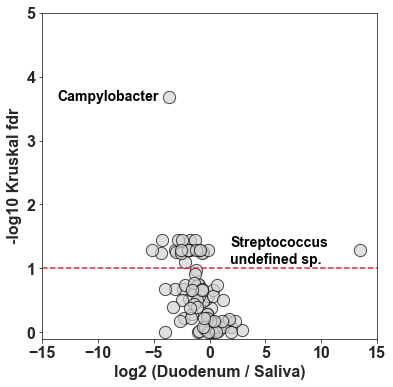

In [8]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
sns.scatterplot(ax=ax1, x='log2 Rel FC', y='-log10 Kruskal fdr', data=df_stats_list[5][df_stats_list[5]['total_nonzero']>5], color='lightgrey', s=150, edgecolor='k', alpha=0.7)
ax1.set_ylim(-0.1, 5)
ax1.set_xlim(-15,15)
ax1.axhline(y=-np.log10(0.1), linestyle='--', color='#DF2935')

ax1.set_ylabel('-log10 Kruskal fdr', fontsize=16, fontweight='bold')
ax1.set_xlabel('log2 (Duodenum / Saliva)', fontsize=16, fontweight='bold')

ax1.set_title('', fontsize=16, fontweight='bold')

sig_taxa = df_stats_list[5][(df_stats_list[5]['-log10 Kruskal fdr']>-np.log10(0.1))]

count=0

for index, row in sig_taxa.iterrows():
    if row['log2 Rel FC']>10:
            ax1.text(row['log2 Rel FC']-11.6, row['-log10 Kruskal fdr']-0.2, 'Streptococcus\nundefined sp.', color='k', fontsize=14)
    else:
        if row['-log10 Kruskal fdr']>3:
            ax1.text(row['log2 Rel FC']-10, row['-log10 Kruskal fdr']-0.05, 'Campylobacter', color='k', fontsize=14)
            
#fig.savefig('duo_sal_volcano.png', dpi=200, bbox_inches='tight')
#fig.savefig('duo_sal_volcano.pdf', bbox_inches='tight', transparent=True)

In [9]:
df_stats_list[5].sort_values('fdr Kruskal p-value').head(n=10)

Comp      ID                                  Group  \
38  Duodenum v Saliva   ASV79                       Campylobacter(g)   
30  Duodenum v Saliva   ASV59                          Prevotella(g)   
34  Duodenum v Saliva   ASV69                      Capnocytophaga(g)   
13  Duodenum v Saliva   ASV22  uncultured Bacteroidetes bacterium(s)   
71  Duodenum v Saliva  ASV152                       Selenomonas 3(g)   
82  Duodenum v Saliva  ASV181                           Lautropia(g)   
16  Duodenum v Saliva   ASV31                        Prevotella 6(g)   
35  Duodenum v Saliva   ASV71                          Bergeyella(g)   
49  Duodenum v Saliva  ASV113                       Mogibacterium(g)   
26  Duodenum v Saliva   ASV52                     Prevotella oris(s)   

    Kruskal p-value  Rel_cond1_average  Rel_cond2_average  Fisher p-value  \
38         0.000002           0.073747           0.926557        0.227659   
30         0.000749           0.085456           0.208618        0.042847   
34         0.002229           0.045992           0.321805        0.097993   
13         0.001457           0.489310           1.627583        0.137848   
71         0.001834           0.047943           0.273451        0.111344   
82         0.001861           0.006636           0.126546        0.067132   
16         0.010280           0.452340           1.788366        0.628766   
35         0.006048           0.197884           0.218484        0.085616   
49         0.008306           0.051413           0.200920        0.471154   
26         0.004953           0.048811           0.276378        0.176291   

   cond1_nonzero_N cond2_nonzero_N total_nonzero  log2 Rel FC  \
38              10              20            30    -3.651233   
30               6              19            25    -1.287614   
34               5              15            20    -2.806743   
13               8              18            26    -1.733911   
71               6              16            22    -2.511885   
82               3              12            15    -4.253153   
16              12              17            29    -1.983163   
35               8              21            29    -0.142868   
49              11              16            27    -1.966428   
26               6              15            21    -2.501380   

    fdr Kruskal p-value  fdr Fisher p-value  -log10 Kruskal fdr  \
38             0.000209            0.936725            3.679894   
30             0.035288            0.813350            1.452370   
34             0.035288            0.845667            1.452370   
13             0.035288            0.898268            1.452370   
71             0.035288            0.845667            1.452370   
82             0.035288            0.813350            1.452370   
16             0.051945            1.000000            1.284453   
35             0.051945            0.813350            1.284453   
49             0.051945            1.000000            1.284453   
26             0.051945            0.898268            1.284453   

    -log10 Fisher fdr  abs log2 Rel FC  
38           0.028388         3.651233  
30           0.089723         1.287614  
34           0.072801         2.806743  
13           0.046594         1.733911  
71           0.072801         2.511885  
82           0.089723         4.253153  
16          -0.000000         1.983163  
35           0.089723         0.142868  
49          -0.000000         1.966428  
26           0.046594         2.501380

### Taxon presence/absence between saliva and duodenum

In [10]:
# Count number of saliva samples each taxon is in
_df = pd.DataFrame(df_abs_sort_list[5][df_abs_sort_list[5]['Body_Site']=='Saliva'][df_abs_sort_list[5].columns[:-4]].astype(bool).sum().sort_values(ascending=False)).rename(columns={0:'Saliva Prevalence (N=21 total)'})

In [11]:
# Count number of duodenum samples each taxon is in
_df['Duodenum Prevalence (N=21 total)'] = df_abs_sort_list[5][df_abs_sort_list[5]['Body_Site']=='Duodenum'][_df.index.tolist()].astype(bool).sum().tolist()

In [12]:
#Calculate average relative abundance for each taxon in saliva and duodenum

saliva_rel_abundance = []
duodenum_rel_abundance = []

for index,row in _df.iterrows():
    saliva_rel_abundance.append(np.mean(df_rel_sort_list[5][df_rel_sort_list[5]['Body_Site']=='Saliva'][index].tolist()))
    duodenum_rel_abundance.append(np.mean(df_rel_sort_list[5][df_rel_sort_list[5]['Body_Site']=='Duodenum'][index].tolist()))

_df['Saliva Rel. Abundance (%)'] = saliva_rel_abundance
_df['Duodenum Rel. Abundance (%)'] = duodenum_rel_abundance

In [13]:
# Merge taxa identifiers with taxonomy labels
_df = _df.merge(df_col_names_list[5][['taxonomy', 'label']], left_index=True, right_index=True)
_df = _df[_df['Saliva Prevalence (N=21 total)']+_df['Duodenum Prevalence (N=21 total)']>5]

In [14]:
# Create column counting the difference in number of samples each taxon is present in between saliva and duodenum
_df['Difference'] = abs(_df['Saliva Prevalence (N=21 total)']-_df['Duodenum Prevalence (N=21 total)'])

In [15]:
_df.sort_values('Difference', ascending=False, inplace=True)

In [16]:
_df.to_excel('STable_3.xlsx')